# Mask R-CNN - Inspect Ballon Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project0
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.mitochondria import mitochondria

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BALLON_WEIGHTS_PATH = "/path/to/mask_rcnn_balloon.h5"  # TODO: update this path

## Configurations

In [11]:
config = mitochondria.MitochondriaConfig()
MITO_DIR = os.path.join(ROOT_DIR, "datasets/mito")

In [12]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        25
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1, 'rpn_bbox_loss': 1, 'mrcnn_class_loss': 1, 'mrcnn_bbox_loss': 1, 'mrcnn_mask_loss': 1}
MASK_POOL_SIZE                 14
MASK_SHAPE                    

## Notebook Preferences

In [13]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [14]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [15]:
# Load validation dataset
dataset = mitochondria.MitochondriaDataset()
dataset.load_Mitochondria(MITO_DIR, "val")


# Must call before using the dataset
dataset.prepare()

dataset2 = mitochondria.MitochondriaDataset()
dataset2.load_Mitochondria(MITO_DIR, "train")


# Must call before using the dataset
dataset2.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

print("Images: {}\nClasses: {}".format(len(dataset2.image_ids), dataset2.class_names))

Images: 17
Classes: ['BG', 'Mitochondria']
Images: 148
Classes: ['BG', 'Mitochondria']


## Load Model

In [16]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

W0812 21:37:29.700807 140425186613056 deprecation_wrapper.py:119] From /home/iecheverria/anaconda3/envs/MaskRCNN3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 21:37:29.705285 140425186613056 deprecation_wrapper.py:119] From /home/iecheverria/anaconda3/envs/MaskRCNN3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 21:37:29.708773 140425186613056 deprecation_wrapper.py:119] From /home/iecheverria/anaconda3/envs/MaskRCNN3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 21:37:29.728285 140425186613056 deprecation_wrapper.py:119] From /home/iecheverria/anaconda3/envs/MaskRCNN3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1919: The 

## Cargar el último modelo o uno en particular

In [17]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()
#weights_path= "/home/iecheverria/Desktop/PRACTICAS/Mask_RCNN-master/logs/mitochondria20190704T1039/mask_rcnn_mitochondria_0094.h5"
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/iecheverria/Desktop/PRACTICAS/Mask_RCNN-master/logs/mitochondria20190812T1203/mask_rcnn_mitochondria_0733.h5
Re-starting from epoch 733


## Cargar las métricas

In [18]:
import time
from keras import backend as K
import tensorflow as tf


def jaccard_index(y_true, y_pred, t=0.5):
    """Define Jaccard index.

       Args:
            y_true (tensor): ground truth masks.
            y_pred (tensor): predicted masks.
            t (float, optional): threshold to be applied.

       Return:
            jac (tensor): Jaccard index value
    """

    y_pred_ = tf.to_int32(y_pred > t)
    y_true = tf.cast(y_true, dtype=tf.int32)

    TP = tf.count_nonzero(y_pred_ * y_true)
    FP = tf.count_nonzero(y_pred_ * (y_true - 1))
    FN = tf.count_nonzero((y_pred_ - 1) * y_true)

    jac = tf.cond(tf.greater((TP + FP + FN), 0), lambda: TP / (TP + FP + FN),
                  lambda: K.cast(0.000, dtype='float64'))
    return jac


def jaccard_loss(y_true, y_pred):
    """Define Jaccard index.

       Args:
            y_true (tensor): ground truth masks.
            y_pred (tensor): predicted masks.

       Return:
            jac (float): Jaccard loss score.
    """

    numerator = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred) - numerator 

    jac =  numerator / (denominator + tf.keras.backend.epsilon())

    return 1 - jac


def dice_loss(y_true, y_pred):
    """Define Dice loss.
       
       Args:
            y_true (tensor): ground truth masks.
            y_pred (tensor): predicted masks.

        Return:
            dice (float): Dice loss score.

        Based on:
        https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation
    """

    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + tf.square(y_pred))

    dice = numerator / (denominator + tf.keras.backend.epsilon())

    return (1 - dice)


def dice_loss2(y_true, y_pred):
    """Define Dice loss without squaring y_predi in the formula.

       Args:
            y_true (tensor): ground truth masks.
            y_pred (tensor): predicted masks.

        Return:
            dice (float): Dice loss score.

        Based on:
        https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation
    """

    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    dice = numerator / (denominator + tf.keras.backend.epsilon())

    return (1 - dice)


def mean_iou(y_true, y_pred):
    """Define IoU metric.

       Args:
            y_true (tensor): ground truth masks.
            y_pred (tensor): predicted masks.

       Return:
            meanIoU (tensor): mean IoU value.
    """

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


def voc_calculation_meanIoU(y_true, y_pred, foreground_iou):
    """Calculate VOC metric value.

        Args:
            y_pred (array): predicted masks.
            y_true (array): ground truth masks.
            foreground_iou (float): foreground IoU score.

        Return:
            voc (float): VOC score value.
    """

    # Invert the arrays
    y_pred[y_pred == 0] = 2
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == 2] = 1

    y_true[y_true == 0] = 2
    y_true[y_true == 1] = 0
    y_true[y_true == 2] = 1

    with tf.Session() as sess:
        ypredT = tf.constant(np.argmax(y_pred, axis=-1))
        ytrueT = tf.constant(np.argmax(y_true, axis=-1))
        iou,conf_mat = tf.metrics.mean_iou(ytrueT, ypredT,
                                           num_classes=3)
        sess.run(tf.local_variables_initializer())
        sess.run([conf_mat])
        background_iou = sess.run([iou])

    voc = (float)(foreground_iou + background_iou)/2

    print("Foreground IoU: " + str(foreground_iou))
    print("Background IoU: " + str(background_iou))
    print("VOC: " + str(voc))

    return voc

def voc_calculation(y_true, y_pred, foreground):
    """Calculate VOC metric value.

        Args:
            y_true (array): ground truth masks.
            y_pred (array): predicted masks.
            foreground (float): foreground Jaccard index score.

        Return:
            voc (float): VOC score value.
    """

    # Invert the arrays
    start_time = time.time()
    y_pred[y_pred == 0] = 2
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == 2] = 1

    y_true[y_true == 0] = 2 
    y_true[y_true == 1] = 0
    y_true[y_true == 2] = 1
    elapsed_time = time.time() - start_time                             
    #print("Time inverting arrays: " + str(elapsed_time))

    start_time = time.time()
    background = jaccard_index(y_true, y_pred)
    elapsed_time = time.time() - start_time                             
    #print("Time calculating jaccard of the background: "+ str(elapsed_time))

    sess = tf.InteractiveSession()
    background = background.eval(session=sess)
 
    voc = (float)(foreground + background)/2

    sess.close()

    return voc


## Detección en una sola imagen de validación/train

Loading weights  /home/iecheverria/Desktop/PRACTICAS/Mask_RCNN-master/logs/mitochondria20190812T1203/mask_rcnn_mitochondria_0733.h5
Re-starting from epoch 733
image ID: Mitochondria.training0150.jpg (9) /home/iecheverria/Desktop/PRACTICAS/Mask_RCNN-master/datasets/mito/val/orig/training0150.jpg


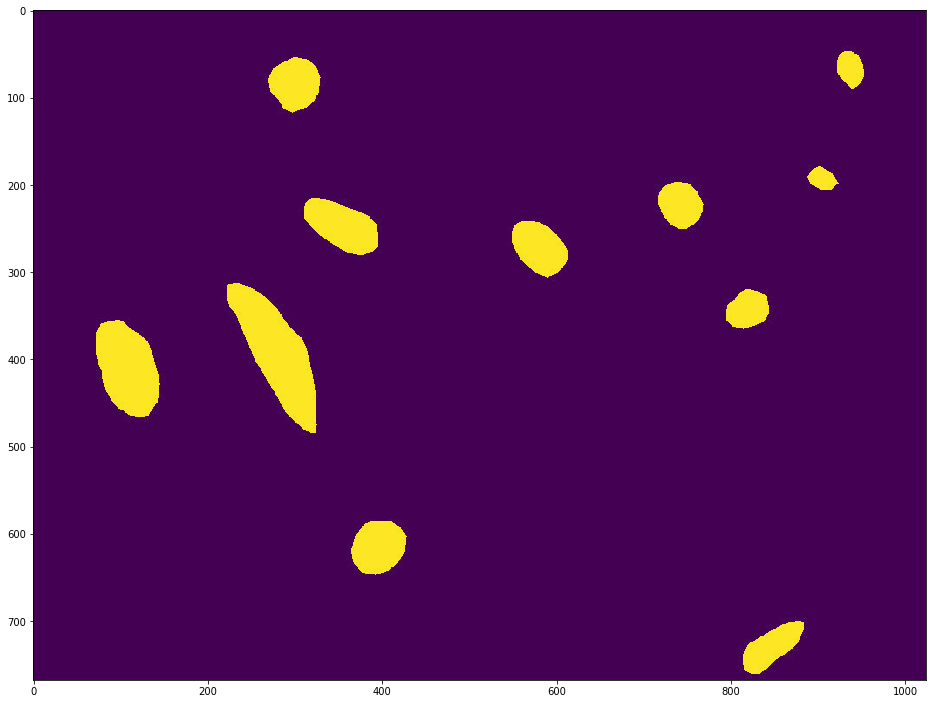

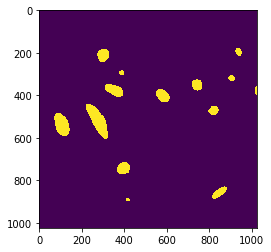

In [20]:
import skimage

weights_path='/home/iecheverria/Desktop/PRACTICAS/Mask_RCNN-master/logs/mitochondria20190812T1203/mask_rcnn_mitochondria_0733.h5'

print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)


image_id = 9 
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=0)

# Display results
ax = get_ax(1)
r = results[0]



pre2=r['masks']*1
ig=np.sum(pre2,axis = 2)


path=dataset.image_reference(image_id)
nuevo=os.path.dirname(os.path.dirname(path))
nuevo=os.path.join(nuevo, 'mask')
path, filename = os.path.split(path)
final=os.path.join(nuevo, filename)

mask = skimage.io.imread(final)

imgplot = plt.imshow(mask)
plt.show()


imgplot = plt.imshow(ig)
plt.show()


## Cargar y calcular el jaccard y voc si se han usado las imaǵenes enteras

Tarda un rato en realizar el proceso

In [ ]:
import skimage

aux=0

folder='/home/iecheverria/Desktop/PRACTICAS/prep/datos/train'

tmorig=np.empty([768, 1024,148])
tfinal=np.empty([768, 1024,148])

for filename in os.listdir(folder+'/orig'):  
    tiorig=skimage.io.imread(folder+'/orig/'+filename)
    tmorig[:,:,aux]=skimage.io.imread(folder+'/mask/'+filename)

    results = model.detect([skimage.color.gray2rgb(tiorig)], verbose=0)
    tfinal[:,:,aux] = np.sum(results[0]['masks']*1,axis = 2)
    
    aux=aux+1
    #print(aux)

tmorig[tmorig<120]=0
tmorig[tmorig>120]=1
tfinal[tfinal>1]=1     

In [ ]:
import skimage

aux=0

folder='/home/iecheverria/Desktop/PRACTICAS/prep/datos/val'

vmorig=np.empty([768, 1024,17])
vfinal=np.empty([768, 1024,17])

for filename in os.listdir(folder+'/orig'):  
    viorig=skimage.io.imread(folder+'/orig/'+filename)
    vmorig[:,:,aux]=skimage.io.imread(folder+'/mask/'+filename)

    results = model.detect([skimage.color.gray2rgb(viorig)], verbose=0)
    vfinal[:,:,aux] = np.sum(results[0]['masks']*1,axis = 2)
    
    aux=aux+1
    #print(aux)

vmorig[vmorig<120]=0
vmorig[vmorig>120]=1
vfinal[vfinal>1]=1  

In [ ]:
import skimage

aux=0

folder='/home/iecheverria/Desktop/PRACTICAS/prep/datos/test'

tsmorig=np.empty([768, 1024,165])
tsfinal=np.empty([768, 1024,165])

for filename in os.listdir(folder+'/orig'):  
    tiorig=skimage.io.imread(folder+'/orig/'+filename)
    tsmorig[:,:,aux]=skimage.io.imread(folder+'/mask/'+filename)

    results = model.detect([skimage.color.gray2rgb(tiorig)], verbose=0)
    tsfinal[:,:,aux] = np.sum(results[0]['masks']*1,axis = 2)
    
    aux=aux+1
    #print(aux)

tsmorig[tsmorig<120]=0
tsmorig[tsmorig>120]=1
tsfinal[tsfinal>1]=1

In [ ]:
sess = tf.InteractiveSession()

jacardt=[]
voc=[]
for t in range(0,145):
    f=jaccard_index(tfinal[:,:,t],tmorig[:,:,t]).eval(session=sess)
    voc.append(voc_calculation(tfinal[:,:,t], tmorig[:,:,t], f))
    #print(f)
    #print(t)
    jacardt.append(f)
print('El resultado de train es: ')

print(np.mean(jacardt))
print(np.mean(voc))

sess.close()


In [ ]:
sess = tf.InteractiveSession()

jacardp=[]
jacardt=[]

voc=[]
for t in range(0,17):
    f=jaccard_index(vfinal[:,:,t],vmorig[:,:,t]).eval(session=sess)
    voc.append(voc_calculation(vfinal[:,:,t], vmorig[:,:,t], f))
    #print(f)
    #print(t)
    jacardt.append(f)
print('El resultado de val es: ')

print(np.mean(jacardt))
print(np.mean(voc))
sess.close()

In [ ]:
sess = tf.InteractiveSession()

jacardt=[]
voc=[]

for t in range(0,165):
    f=jaccard_index(tsfinal[:,:,t],tsmorig[:,:,t]).eval(session=sess)
    
    print(f)
    print(t)
    if(f<0.75):
        imgplot = plt.imshow(tsmorig[:,:,t])
        plt.show()
        imgplot = plt.imshow(tsfinal[:,:,t])
        plt.show()
        
    voc.append(voc_calculation(tsfinal[:,:,t], tsmorig[:,:,t], f))
    jacardt.append(f)
print('El resultado de test es:')

print(np.mean(jacardt))
print(np.mean(voc))

sess.close()

## Cargar y calcular el jaccard y voc si se han usado crops de 256x256

Tarda un rato en realizar el proceso

In [ ]:
import skimage
import imageio

aux=0

folder='/home/iecheverria/Desktop/PRACTICAS/prep/datos/train'

tmorig=np.empty([768, 1024,148])
tfinal=np.empty([768, 1024,148])

for filename in os.listdir(folder+'/orig'):  
    tiorig=skimage.io.imread(folder+'/orig/'+filename)
    tmorig[:,:,aux]=skimage.io.imread(folder+'/mask/'+filename)

    print(aux)
    for i in range(0,4):
        for j in range(0,3):
            results = model.detect([skimage.color.gray2rgb(tiorig[j*256:(j+1)*256,i*256:(i+1)*256])], verbose=0)
            tfinal[j*256:(j+1)*256,i*256:(i+1)*256,aux]=np.sum(results[0]['masks']*1,axis = 2)
            
    imageio.imwrite('trainpred/'+filename,(tfinal[:,:,aux]*255).astype(np.uint8))
    imageio.imwrite('trainorig/'+filename,(tmorig[:,:,aux]).astype(np.uint8))
    
    aux=aux+1

tmorig[tmorig<120]=0
tmorig[tmorig>120]=1
tfinal[tfinal>1]=1     

In [ ]:


folder='/home/iecheverria/Desktop/PRACTICAS/prep/datos/val'

vmorig=np.empty([768, 1024,17])
vfinal=np.empty([768, 1024,17])

aux=0
for filename in os.listdir(folder+'/orig'):
    viorig=skimage.io.imread(folder+'/orig/'+filename)
    vmorig[:,:,aux]=skimage.io.imread(folder+'/mask/'+filename)
    print(aux)
    for i in range(0,4):
        for j in range(0,3):
            results = model.detect([skimage.color.gray2rgb(viorig[j*256:(j+1)*256,i*256:(i+1)*256])], verbose=0)
            vfinal[j*256:(j+1)*256,i*256:(i+1)*256,aux]=np.sum(results[0]['masks']*1,axis = 2)  
    
    
    aux=aux+1

vmorig[vmorig<120]=0
vmorig[vmorig>120]=1
vfinal[vfinal>1]=1    

In [ ]:
import skimage

aux=0

folder='/home/iecheverria/Desktop/PRACTICAS/prep/datos/test'

morig=np.empty([768, 1024,165])
final=np.empty([768, 1024,165])

for filename in os.listdir(folder+'/orig'):
    
    iorig=skimage.io.imread(folder+'/orig/'+filename)
    morig[:,:,aux]=skimage.io.imread(folder+'/mask/'+filename)
    print(aux)
    for i in range(0,4):
        for j in range(0,3):
            results = model.detect([skimage.color.gray2rgb(iorig[j*256:(j+1)*256,i*256:(i+1)*256])], verbose=0)
            final[j*256:(j+1)*256,i*256:(i+1)*256,aux]=np.sum(results[0]['masks']*1,axis = 2)  
    aux=aux+1

morig[morig<120]=0
morig[morig>120]=1
final[final>1]=1    

In [ ]:
sess = tf.InteractiveSession()

jacardt=[]
voc=[]
for t in range(0,148):
   
    f=jaccard_index(tfinal[:,:,t],tmorig[:,:,t]).eval(session=sess)
    voc.append(voc_calculation(tfinal[:,:,t], tmorig[:,:,t], f))
    #print(f)
    #print(t)
    jacardt.append(f)
    
print('El resultado de train es: ')

print(np.mean(jacardt))
print(np.mean(voc))

sess.close()


In [ ]:
sess = tf.InteractiveSession()

jacardt=[]
voc=[]
for t in range(0,17):
    f=jaccard_index(vfinal[:,:,t],vmorig[:,:,t]).eval(session=sess)
    voc.append(voc_calculation(vfinal[:,:,t], vmorig[:,:,t], f))
    #print(f)
    #print(t)
    jacardp.append(np.mean(jacard))
    jacardt.append(f)
print('El resultado de validation es: ')
print(np.mean(jacardt))
print(np.mean(voc))

sess.close()

W0809 10:14:42.010640 140539805800256 deprecation.py:323] From <ipython-input-9-9c07b1a0a864>:18: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


0.8598665678280207
0
0.8524499555427391
1
0.8314495230743784
2
0.7525506319476168
3
0.8855871708888078
4
0.8195127478753541
5
0.8495460849829782
6
0.8392722531222623
7
0.8090646094503375
8


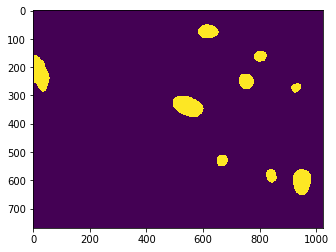

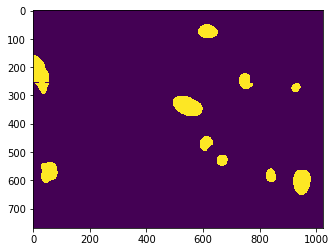

0.7178568089019106
9
0.8951451371888214
10
0.8659076330981398
11
0.8449143404816102
12
0.7948539136707947
13
0.8426231530892377
14
0.8275664673705635
15
0.8684795179256193
16
0.8743965256034744
17
0.753320939665371
18
0.8464671146406028
19
0.7650410927522121
20
0.7820734932068935
21
0.8914124348329794
22
0.8606527380397897
23


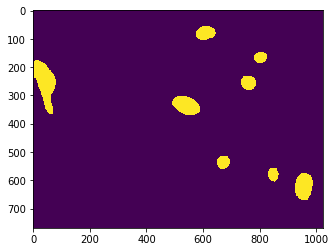

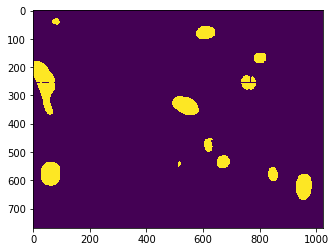

0.7289589546939356
24


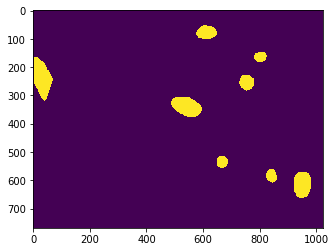

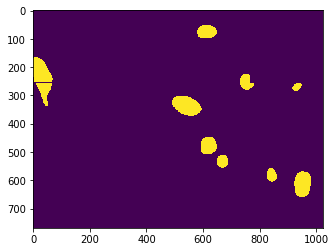

0.7344512097931079
25
0.8956671797024393
26
0.868484761034422
27


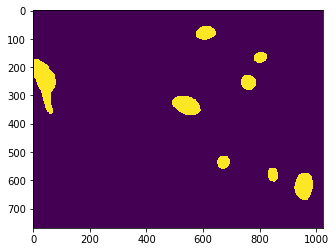

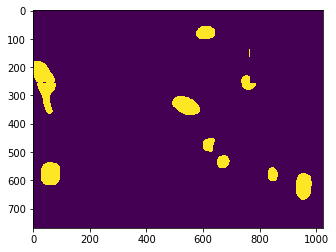

0.6855090832277144
28
0.8792326170653855
29
0.8910589222985662
30
0.8764457976718713
31
0.9080242573387238
32
0.8102187704474979
33
0.8487408402931106
34
0.8898393286931633
35
0.7967160334835802
36


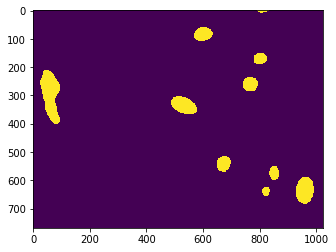

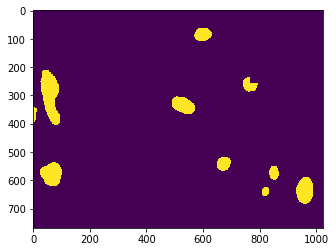

0.7051226737998677
37
0.8565687013313238
38
0.8916059943191094
39
0.8460128485754453
40
0.9161632243571569
41
0.7761855182205395
42
0.8537438382948256
43


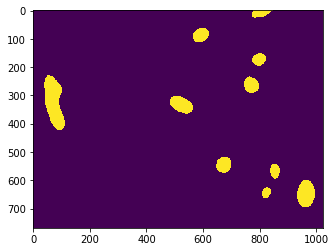

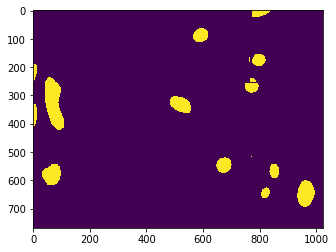

0.7454875632841734
44
0.8812549836455061
45
0.8007374873758132
46
0.8763470502731693
47
0.8628459466078864
48
0.8921087517733796
49
0.7619524190781196
50


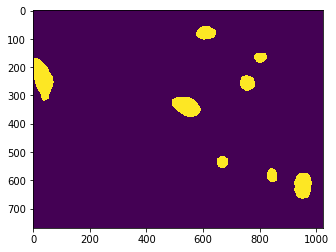

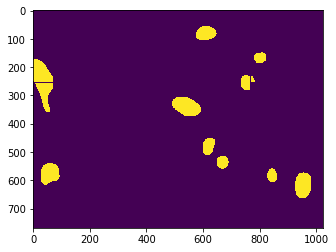

0.7195326525206746
51
0.8533399553017135
52
0.8905295147491163
53
0.9002112967521293
54
0.7643827125711388
55
0.8690683373941293
56
0.9087752928647498
57
0.8674738279472007
58
0.9137577002053389
59
0.8781988350022907
60
0.8424365025848505
61
0.7770918606991881
62
0.8454649691602087
63
0.8491708344301132
64
0.9002531327796489
65
0.8278229908443541
66


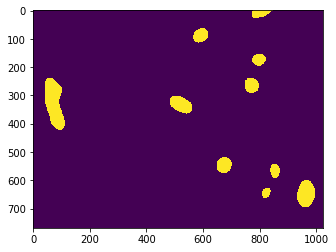

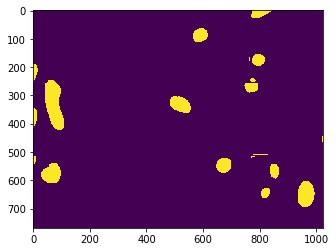

0.7374944543034605
67
0.7872957180681092
68
0.8312691206947597
69
0.8495343118992623
70
0.8769078973863316
71


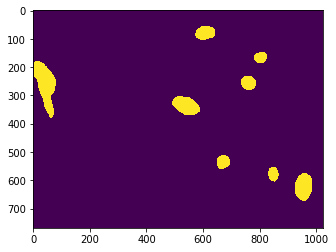

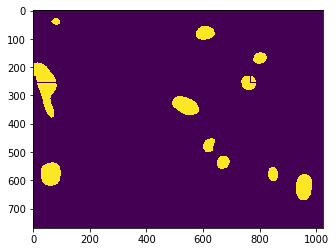

0.7338772772996535
72
0.8382888736018752
73
0.8566215508861138
74
0.9015124868097081
75
0.8740660637042863
76
0.8948534683148313
77
0.9192743080962424
78
0.842810746973723
79
0.8660066216732459
80
0.892579783378549
81
0.7756641836375843
82
0.7724585282858358
83
0.763795238750516
84
0.8142936572430606
85
0.9086186791052687
86
0.788096323305986
87
0.7783684830854879
88
0.8722891943024219
89
0.7688093811521013
90
0.9037525547291461
91


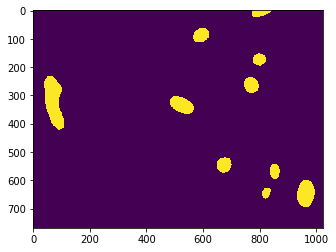

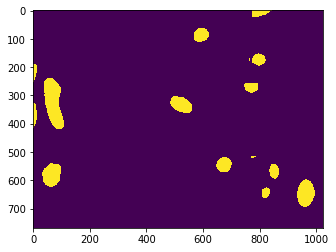

0.7380632421907138
92
0.8622067165570322
93
0.8258515404708773
94
0.8249027237354085
95
0.9055203695574925
96
0.833123266952357
97
0.9015642789960893
98
0.8621806518888344
99
0.751831262262917
100
0.8779338267856013
101
0.8091716753990923
102
0.9133514457597516
103
0.8514067784413902
104
0.8396403236138461
105


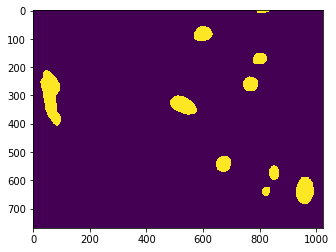

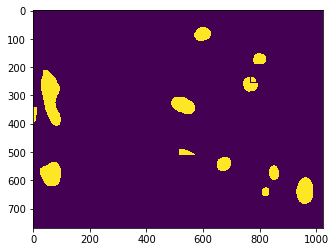

0.7146876758581879
106
0.7934529943204965
107
0.8639125151883353
108
0.866156124925152
109
0.8682377173320409
110
0.7540979858713792
111
0.8364661654135338
112
0.8939840413203987
113
0.8703198458574181
114
0.818736570691878
115
0.8230196509215184
116
0.8708300366165566
117
0.8347121832273796
118


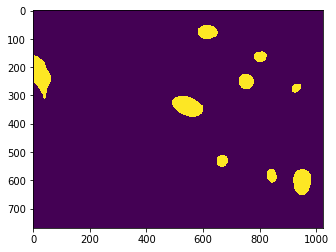

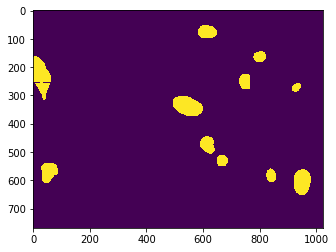

0.7499314672108678
119
0.9036735428430027
120
0.8553875236294896
121
0.7866545924099881
122
0.8951036915928061
123
0.7969580520040224
124
0.8679373087613576
125
0.8349583453785708
126
0.7746389317830865
127
0.8488595288545432
128
0.9170569501686024
129
0.8186126669538992
130
0.8232972836649013
131
0.9075984990619137
132
0.8986622073578595
133
0.8049426694868084
134
0.8885763809399222
135
0.8447519337129329
136
0.7895793794412322
137
0.8099085568715424
138
0.7808914756532778
139
0.8114050437467833
140
0.8142959380625013
141
0.7626862352679564
142
0.8846020159888773
143
0.8447337856837215
144
0.8714589051737531
145
0.8187497933952597
146
0.7669245961083951
147
0.837566265060241
148
0.816556453588048
149
0.7728695311990611
150
0.8198282409300696
151
0.8558039194358333
152
0.8933420064208826
153
0.8766867750816121
154


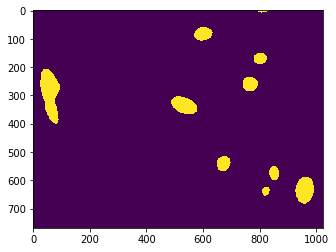

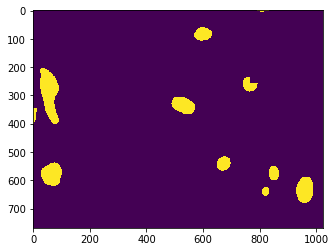

0.7133963636363636
155
0.7945647370746797
156
0.888556923353401
157
0.7645794526436452
158
0.862200047517225
159


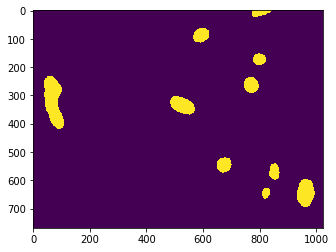

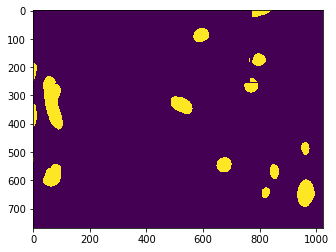

0.7331827106700018
160
0.879081015719468
161
0.7527715549428456
162
0.8506126609204316
163
0.859431720678503
164
finallllllllll
0.8340289346944887


In [12]:
sess = tf.InteractiveSession()

jacardp=[]
jacardt=[]

jacardpp=[]

voc=[]

import imageio

for t in range(0,165):
   
    f=jaccard_index(final[:,:,t],morig[:,:,t]).eval(session=sess)
    """
    if(f<0.75):
        imgplot = plt.imshow(morig[:,:,t])
        plt.show()
        imgplot = plt.imshow(final[:,:,t])
        plt.show()
    """
    voc.append(voc_calculation(final[:,:,t], morig[:,:,t], f))
    print(f)
    print(t)
    jacardt.append(f)
print('El resultado de test es: ')

print(np.mean(jacardt))
print(np.mean(voc))
sess.close()

## Accuraccy de una imagen y del conjunto de entrenamineto/validación

La primera parte permite calcular la accuracy y unos gráficos relacionados con esta métrica de una sola image. La última celda calcula el de todo el conjunto de validación. Se puede cambiar al conjunto de entrenamiento cambiando dataset.image_ids por dataset2.image y cambiando el número de imágenes que hay en el conjunto.

image ID: Mitochondria.training0000.jpg (2) /home/iecheverria/Desktop/PRACTICAS/Mask_RCNN-master/datasets/mito/val/orig/training0000.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  222.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -140.70000  max:   81.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261120, 4)        min:   -0.08847  max:    1.05719  float32
gt_class_id              shape: (22,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (22, 4)               min:   64.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 22)      min:    0.00000  max:    1.00000  float64


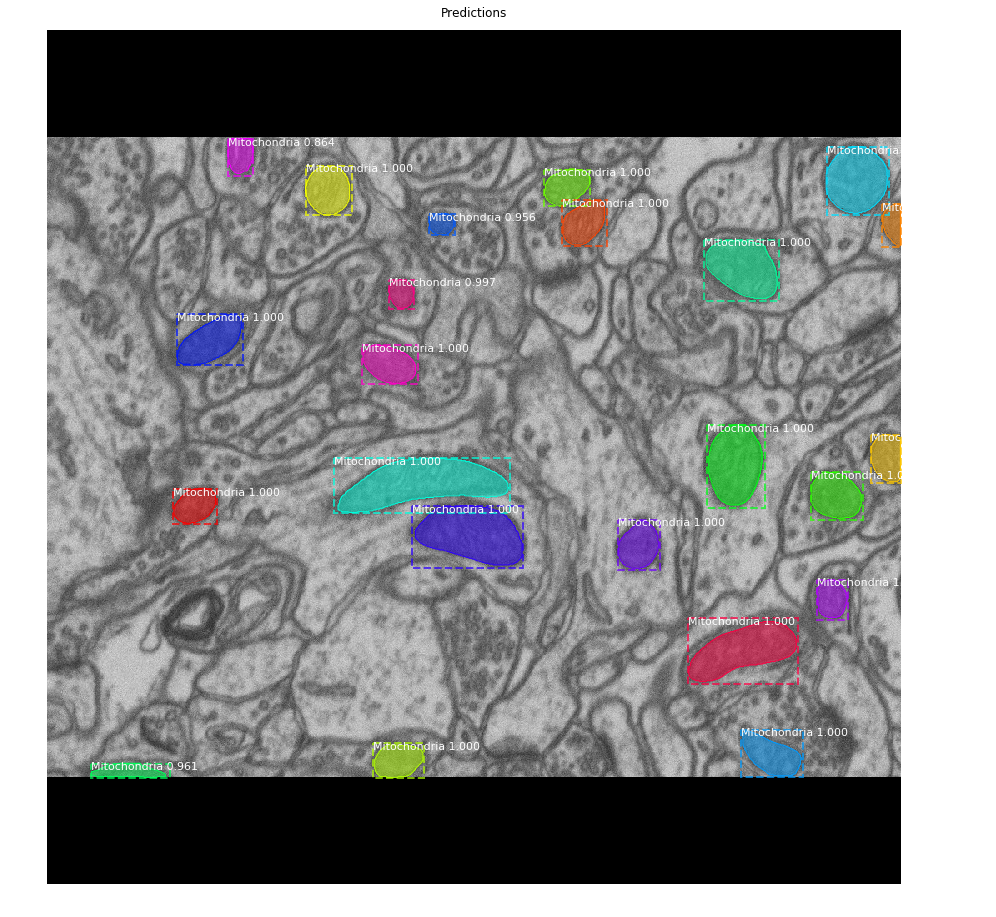

In [11]:
image_id = 2
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)



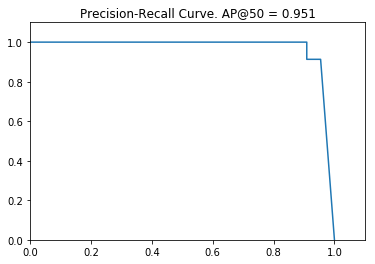

In [12]:
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.9980237147082454


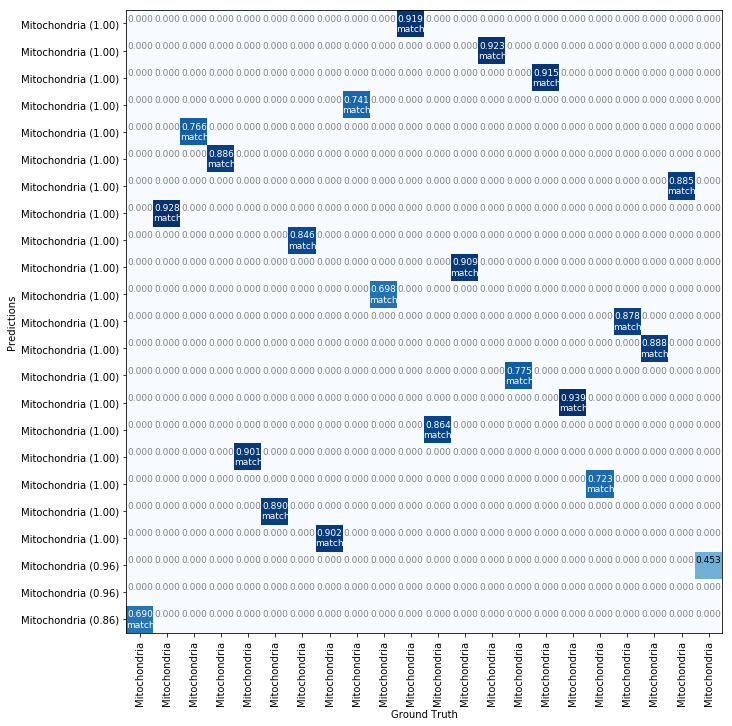

In [13]:
# Grid of ground truth objects and their predictions
image_id=2
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

# Load image
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
results = model.detect([image], verbose=0)
        # Compute AP
r = results[0]
AP, precisions, recalls, overlaps =\
utils.compute_ap(gt_bbox, gt_class_id, gt_mask,r['rois'], r['class_ids'], r['scores'], r['masks'],iou_threshold=0.5)

print(AP)

In [14]:
#Número de imágenes del conjunto de validación
val=17
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        if(len(gt_class_id)!=1):
            APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, val)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.9748172365567264


## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

image ID: Mitochondria.training0110.jpg (8) /home/iecheverria/Desktop/PRACTICAS/Mask_RCNN-master/datasets/mito/val/orig/training0110.jpg
target_rpn_match         shape: (258048,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -3.20408  max:    2.98311  float64
positive_anchors         shape: (46, 4)               min:   56.00000  max:  960.00000  float64
negative_anchors         shape: (210, 4)              min:  -42.50967  max: 1045.25483  float64
neutral anchors          shape: (257792, 4)           min:  -90.50967  max: 1098.50967  float64
refined_anchors          shape: (46, 4)               min:   56.00000  max:  957.00000  float32


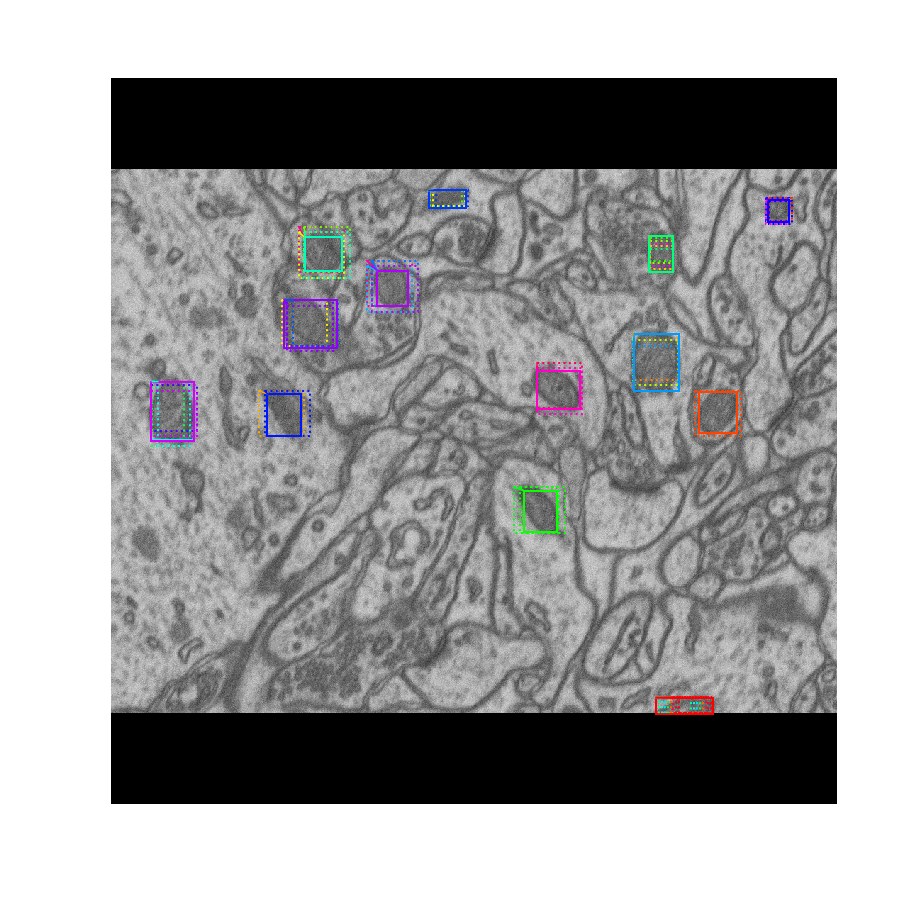

In [11]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
image_id = 8
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
results = model.detect([image], verbose=0)
# Display results

target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())


### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [12]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 3000, 4)          min:   -0.02591  max:    1.00715  float32
refined_anchors          shape: (1, 3000, 4)          min:   -0.00505  max:    1.00133  float32
refined_anchors_clipped  shape: (1, 3000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 2701.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


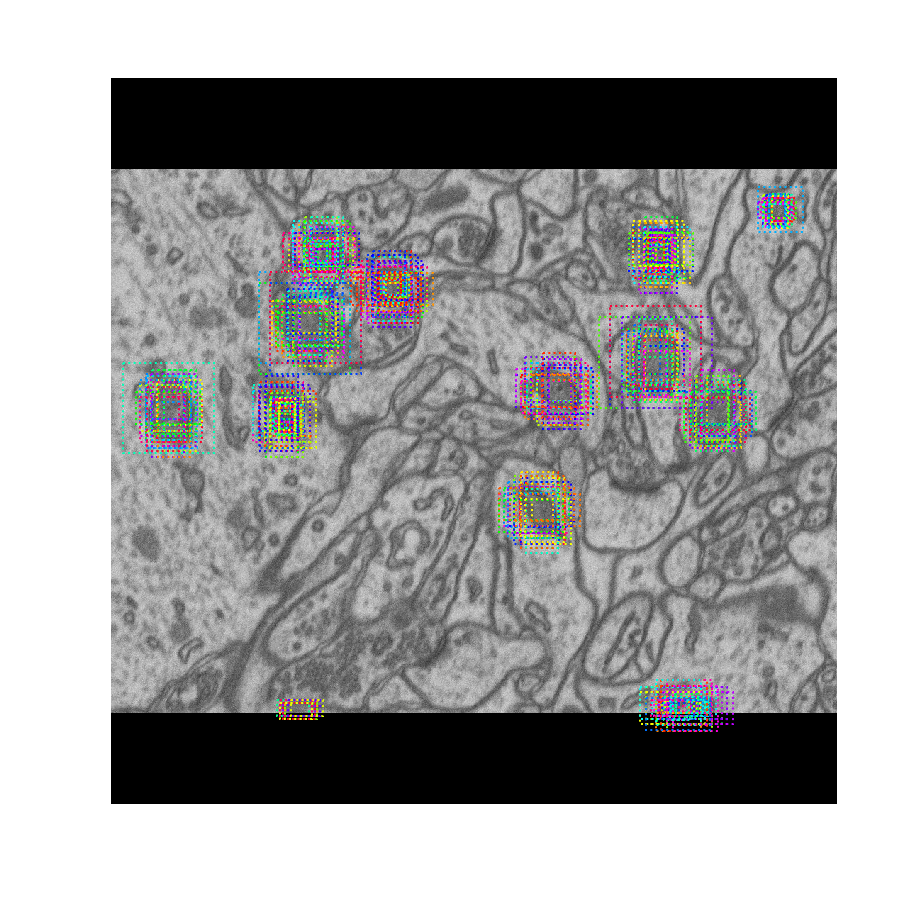

In [14]:
# Show top anchors by score (before refinement)
limit = 500
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

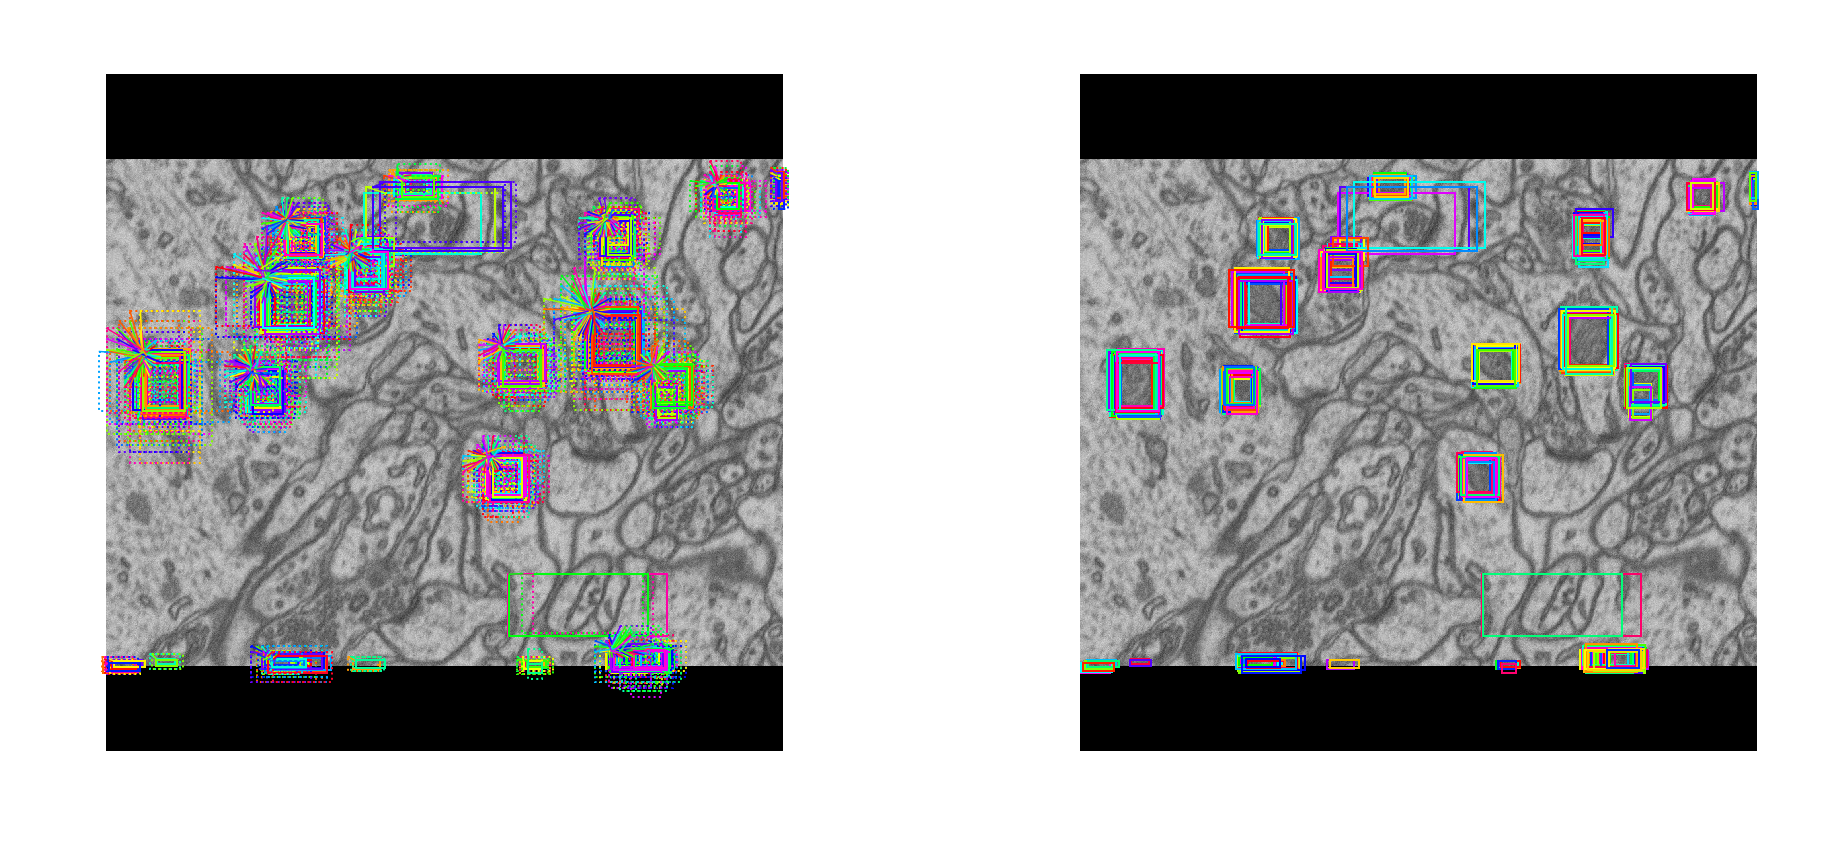

In [15]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 2000
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

# Show refined anchors after non-max suppression
limit = 400
ixs = rpn["post_nms_anchor_ix"][:limit]
print(rpn["post_nms_anchor_ix"].shape)
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

(1, 1000, 4)


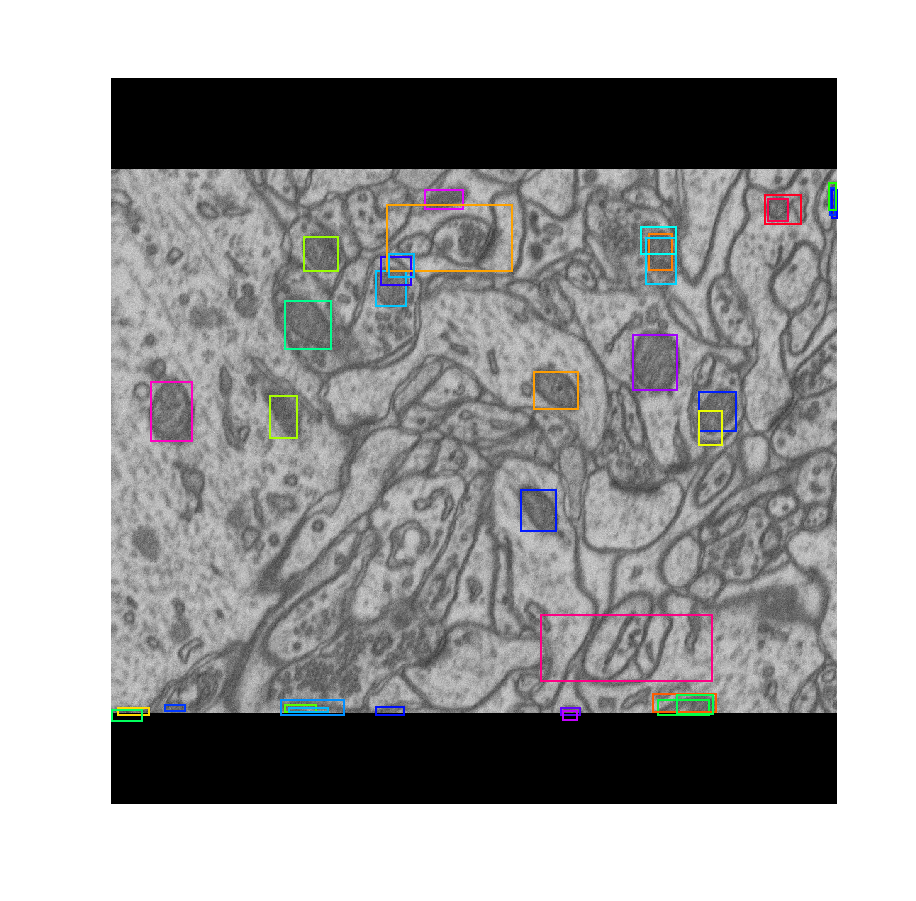

In [16]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 300
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
print(rpn['proposals'].shape)
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [17]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -3.75460  max:    5.84261  float32
masks                    shape: (1, 25, 28, 28, 2)    min:    0.00000  max:    1.00000  float32
detections               shape: (1, 25, 6)            min:    0.00000  max:    1.00000  float32


12 detections: ['Mitochondria' 'Mitochondria' 'Mitochondria' 'Mitochondria'
 'Mitochondria' 'Mitochondria' 'Mitochondria' 'Mitochondria'
 'Mitochondria' 'Mitochondria' 'Mitochondria' 'Mitochondria']


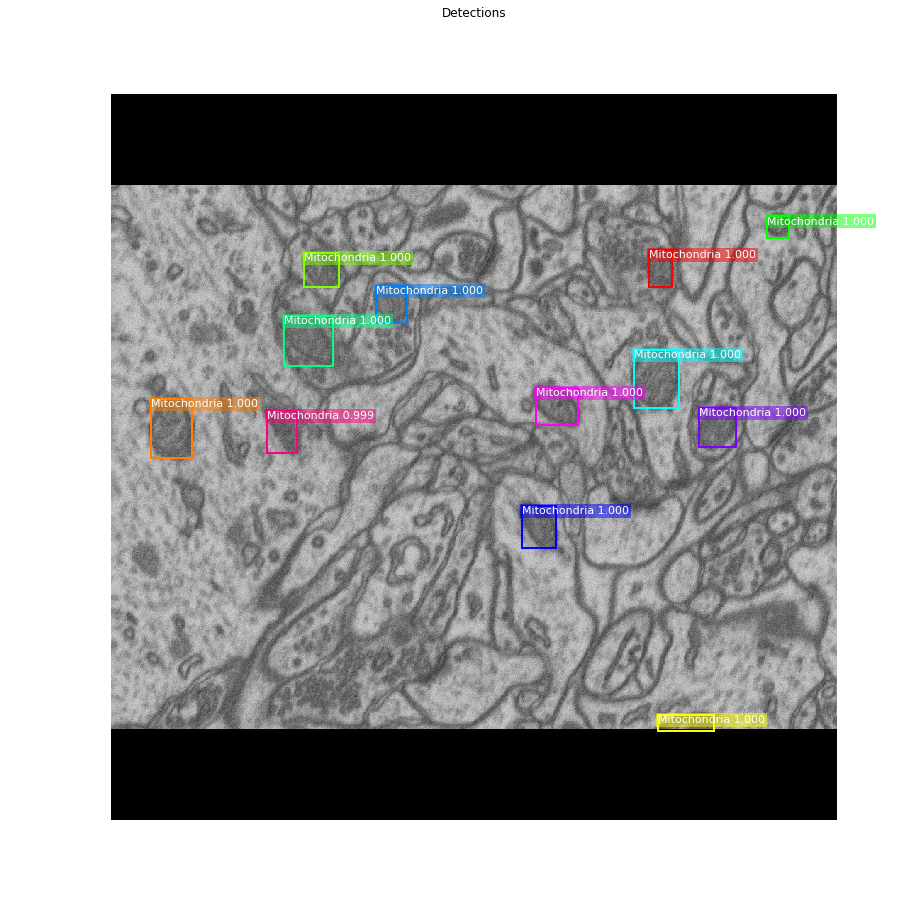

In [18]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [31]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

500 Valid proposals out of 500
39 Positive ROIs
[('BG', 461), ('Mitochondria', 39)]


gt_class_id              shape: (1,)                  min:    0.00000  max:    0.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max:    2.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:    0.00000  float64


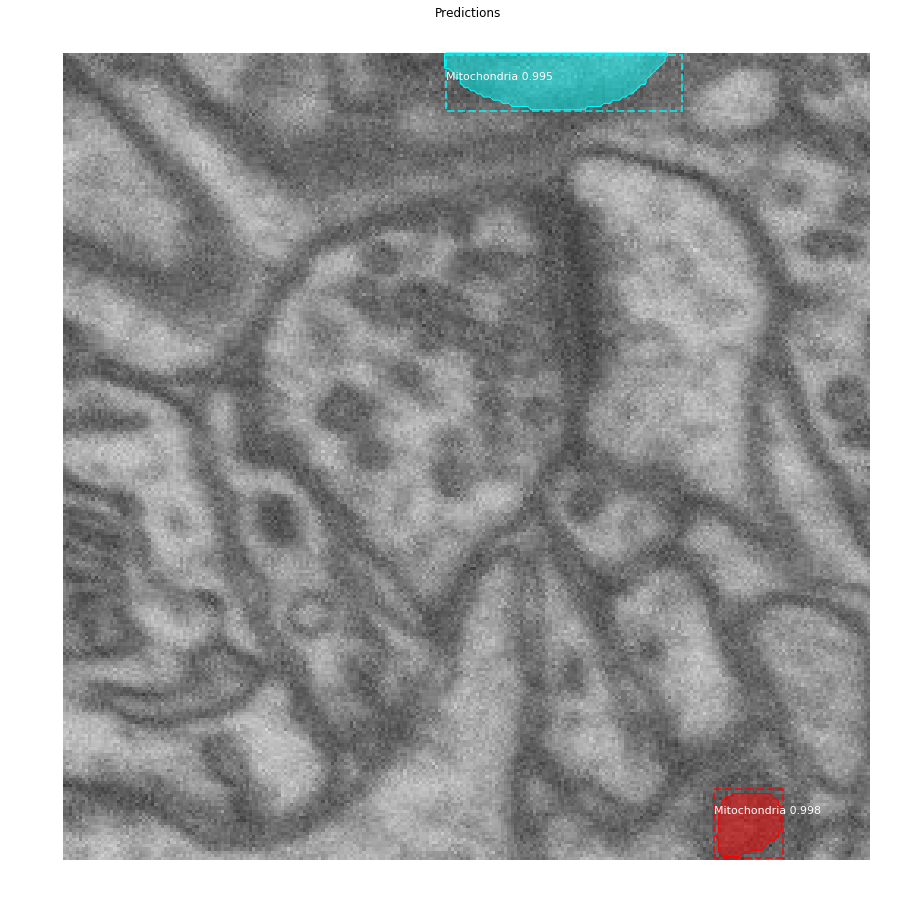

In [32]:

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

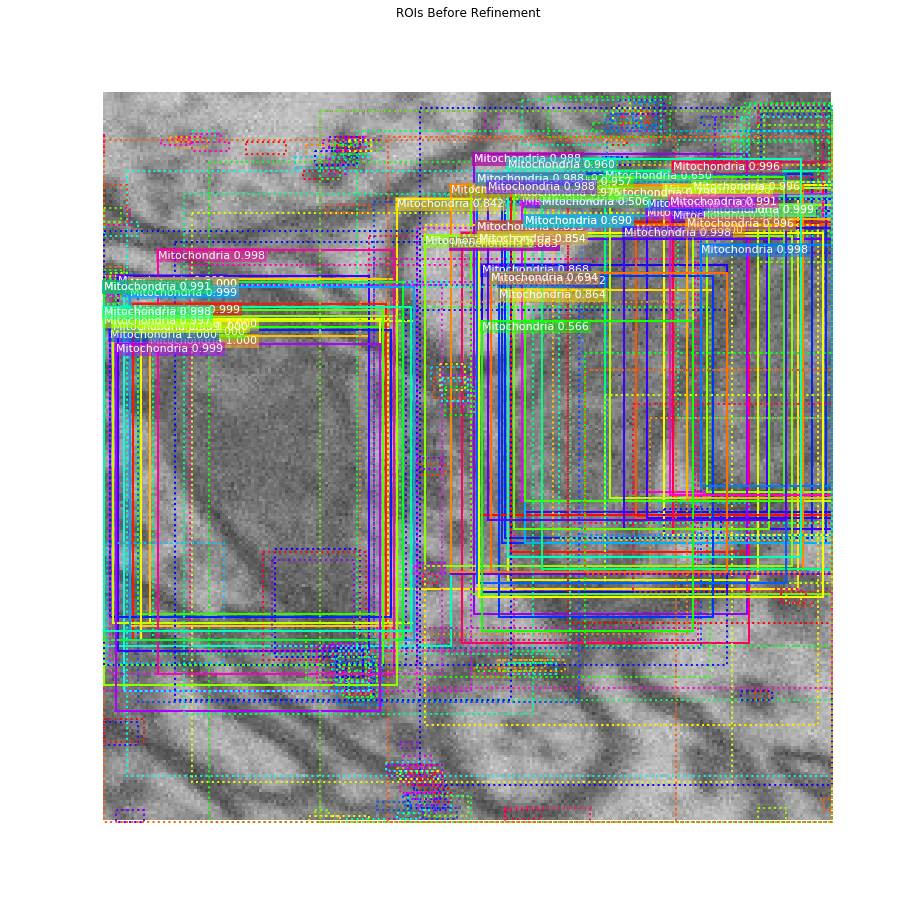

In [29]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 400
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (55, 4)               min:   -2.22233  max:    2.32201  float32
refined_proposals        shape: (55, 4)               min:    0.00000  max:  257.00000  int32


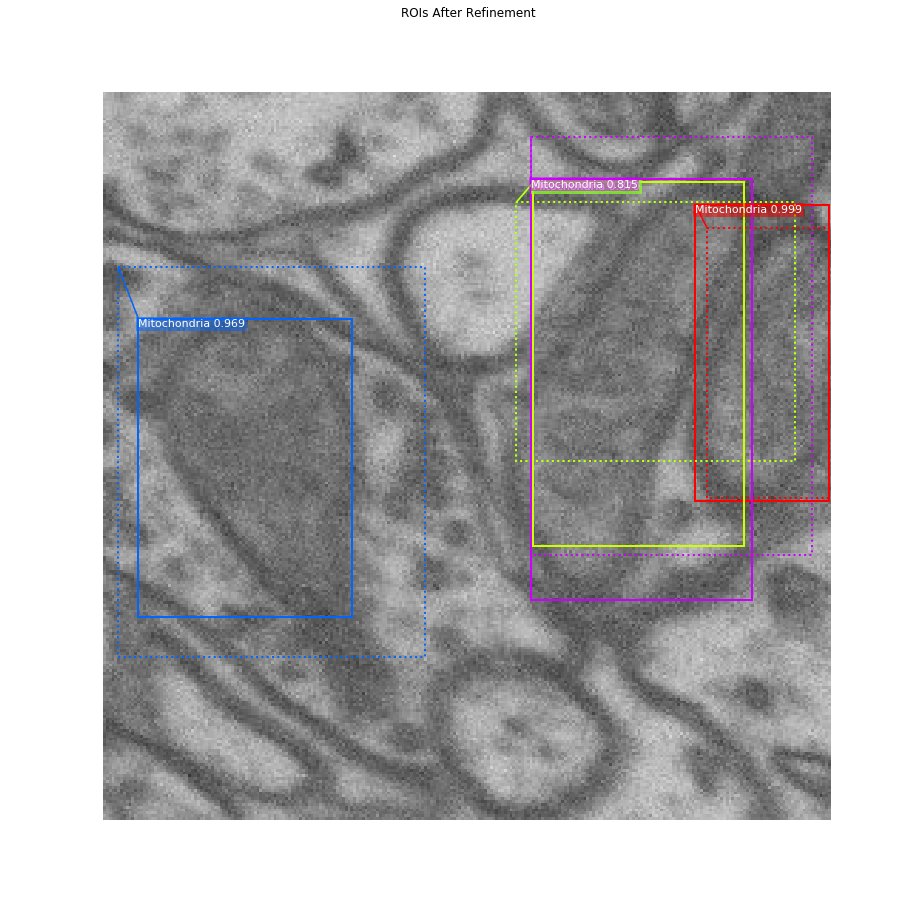

In [24]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [23]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 43 detections:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 20 23 24 26 27 30
 31 33 34 35 36 37 38 39 40 41 43 44 45 46 47 48 50 52 53]


In [24]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 41:
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 18 20 23 24 26 27 30 31
 33 34 35 36 37 38 39 41 43 44 45 46 47 48 50 52 53]


#### Per-Class Non-Max Suppression

In [25]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

Mitochondria          : [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 18 20 23 24 26 27 30 31
 33 34 35 36 37 38 39 41 43 44 45 46 47 48 50 52 53] -> [ 1 16 53  2]

Kept after per-class NMS: 4
[ 1  2 16 53]


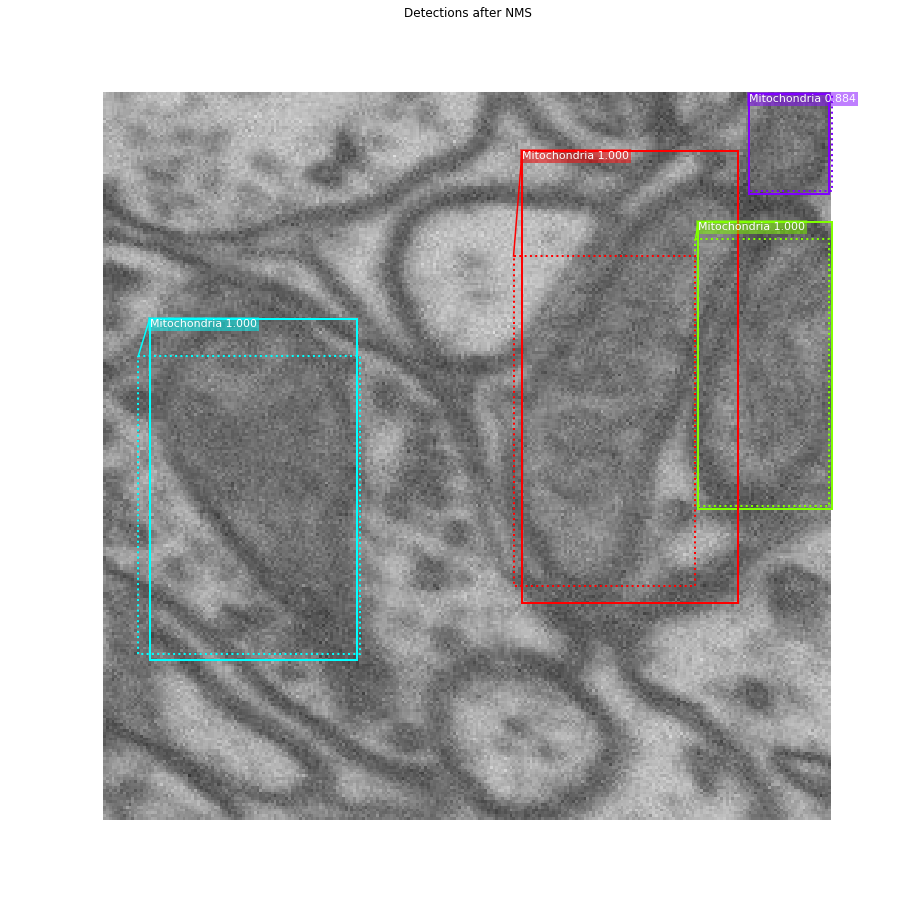

In [26]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

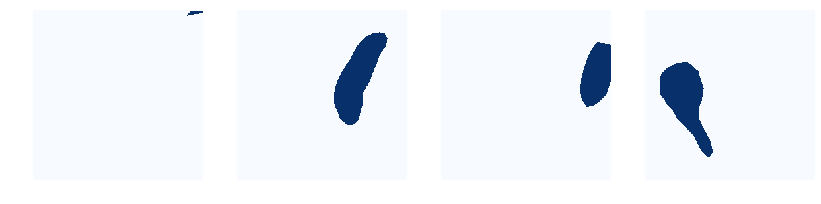

In [27]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [28]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 8, 6)             min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 8, 28, 28, 2)     min:    0.00000  max:    1.00000  float32
4 detections: ['Mitochondria' 'Mitochondria' 'Mitochondria' 'Mitochondria']


In [29]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (4, 28, 28)           min:    0.00000  max:    1.00000  float32
det_masks                shape: (4, 256, 256)         min:    0.00000  max:    1.00000  bool


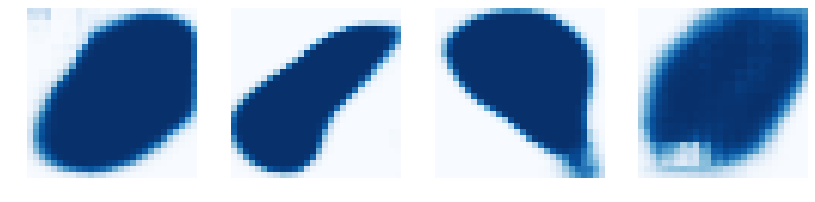

In [30]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

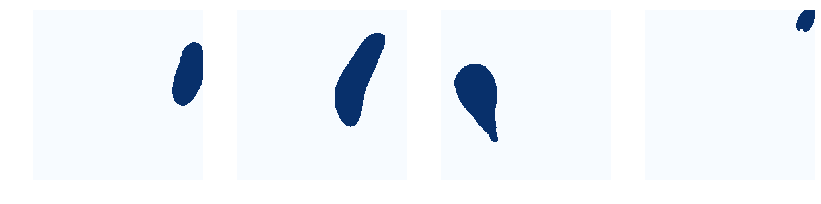

In [31]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [32]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 256, 256, 3)      min:  -90.70000  max:   83.30000  float32
res2c_out                shape: (1, 64, 64, 256)      min:    0.00000  max:    7.27777  float32
res3c_out                shape: (1, 32, 32, 512)      min:    0.00000  max:    7.28155  float32
rpn_bbox                 shape: (1, 16368, 4)         min:  -34.74087  max:   31.80929  float32
roi                      shape: (1, 55, 4)            min:    0.00000  max:    1.00000  float32


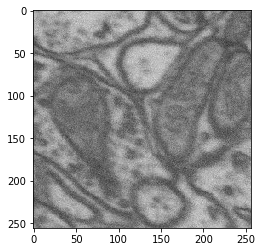

In [33]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

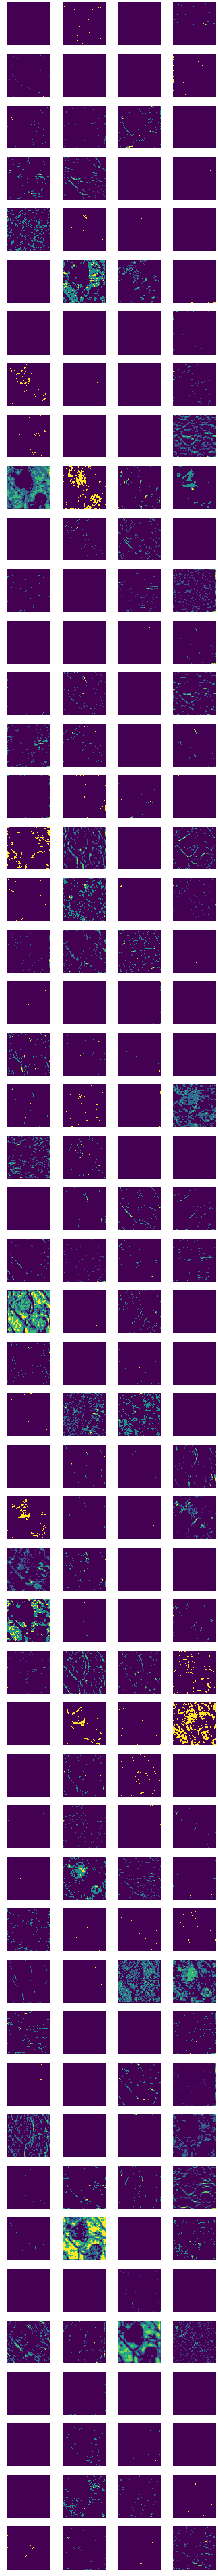

In [35]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:200]))

#display_images(np.transpose(activations["input_image"][0,:,:,:4], [2, 0, 1]), cols=4)

#display_images(np.transpose(activations["rpn_bbox"], [2, 0, 1]), cols=4)

